In [2]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import datetime as dt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.variables import CdecStationVariables
import pickle

<Axes: >

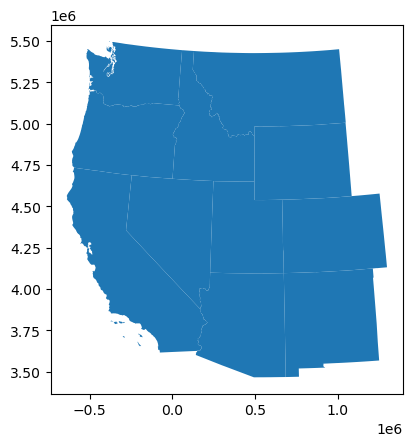

In [4]:
wstates = gpd.read_file('../data/misc/western_states.shp')

wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

wstates.plot()

## Access CDEC:

In [5]:
pkl_fn = '../data/cdec/cdec_locations.pkl'

if os.path.exists(pkl_fn):
    cdec_locations = pickle.load(open(pkl_fn, 'rb'))
else:
    vrs = [
        #CdecStationVariables.SWE,
        CdecStationVariables.SNOWDEPTH
    ]
    points = CDECPointData.points_from_geometry(wstates_boundary.to_crs('epsg:4326'), vrs, 
                                                snow_courses=False)
    cdec_locations = points.to_dataframe()
    cdec_locations.set_crs('epsg:4326')    
    cdec_locations.to_pickle(pkl_fn)

cdec_locations.head()

,name,id,datasource,geometry
0,GREYHORSE 2 NODE 7,G07,CDEC,POINT Z (-120.35160 39.13071 6200.00000)
1,GREYHORSE 2 NODE 1,G01,CDEC,POINT Z (-120.34932 39.12893 6200.00000)
2,COTTONWOOD NODE 8,CT8,CDEC,POINT Z (-120.38163 39.10828 6200.00000)
3,COTTONWOOD NODE 6,CT6,CDEC,POINT Z (-120.38199 39.10760 6200.00000)
4,COTTONWOOD NODE 4,CT4,CDEC,POINT Z (-120.38247 39.10751 6200.00000)


In [10]:
# cdec_ids = []

# for i in range(len(cdec_locations)):
#     cdec_ids.append(cdec_locations.id.values[i])

(37.0, 41.0)

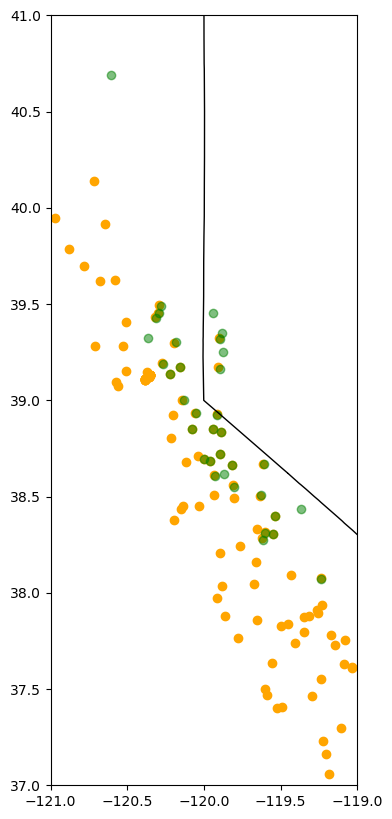

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

cdec_locations.plot(ax=ax, facecolor='orange')
#western_snotel.to_crs('epsg:4326').plot(facecolor='green', ax=ax, alpha=.5)
wstates.loc[wstates['NAME']=='California'].to_crs('epsg:4326').plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_xlim(-121,-119)
ax.set_ylim(37,41)

Concatenating snow depth dataframes:
* Make an empty dataframe with index datetime from one of the cdec dataframes
* download snow depth data for a station
* reindex from multiindex to datetime index
* Add SNOWDEPTH colum as the site name horizontally to the new dataframe making sure the datetime index matches up
* Iterate over all stations

In [8]:
# Download data for Dan to get the datetime index:
pkl_fn = '../data/cdec/cdec_depth.pkl'

if os.path.exists(pkl_fn):
    cdec_depth = pickle.load(open(pkl_fn, 'rb'))
else:
    cdec_point = CDECPointData("DAN", "DAN")
    dan_depth_multiindex = cdec_point.get_daily_data(
        datetime(2003,3,1), datetime(2023,4,2),
        [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH])
    # Reindex from a multiindex so I can use the datetime index:
    dan_depth_resetindex = dan_depth_multiindex.reset_index()
    dan_depth = dan_depth_resetindex.set_index('datetime')

In [11]:
pkl_fn = '../data/cdec/cdec_depth.pkl'

if os.path.exists(pkl_fn):
    cdec_depth = pickle.load(open(pkl_fn, 'rb'))
else:
    # Create a new empty dataframe with the TUM datetime index:
    cdec_depth = pd.DataFrame()
    cdec_depth.index = pd.DatetimeIndex(data=dan_depth.index)
    
    # Iteratively download all the data and add the SNOWDEPTH column to the snwd_df:
    for i in range(len(cdec_locations)):
        cdec_point = CDECPointData(cdec_locations.id.values[i], cdec_locations.id.values[i])
        point_depth = cdec_point.get_daily_data(
            datetime(2003,3,1), datetime(2023,4,2),
            [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH]
        )
        if point_depth is not None:
            point_depth = point_depth.reset_index()
            point_depth = point_depth.set_index('datetime')
            point_depth = point_depth.drop(columns={'site','geometry','SNOWDEPTH_units','datasource'})
            point_depth = point_depth.rename(columns={'SNOWDEPTH':f'{cdec_locations.id.values[i]}'})
            cdec_depth = pd.concat((cdec_depth, point_depth), axis=1)
            #cdec_depth[f'{cdec_locations.id.values[i]}'] = point_depth['SNOWDEPTH']
                
        else:
            continue
    cdec_depth.to_pickle(pkl_fn)

In [12]:
cdec_snwd_april1 = cdec_depth.loc[cdec_depth.index.month == 4] 
cdec_snwd_april1 = cdec_snwd_april1.loc[cdec_snwd_april1.index.day == 1]
cdec_snwd_april1_nan = cdec_snwd_april1.dropna(axis=1)

In [13]:
cdec_snwd_april1_nan.head()

,DAN,HOR,INN,TK2,MRL,RCK,BLK,IDC,SDW
datetime,,,,,,,,,
2005-04-01 08:00:00+00:00,114.0,79.0,47.0,60.0,87.0,61.0,101.0,67.0,98.0
2006-04-01 08:00:00+00:00,129.0,100.0,43.0,53.0,93.0,73.0,98.0,53.0,122.0
2007-04-01 08:00:00+00:00,30.0,28.0,18.0,19.0,27.0,5.0,37.0,22.0,32.0
2008-04-01 08:00:00+00:00,58.0,42.0,36.0,38.0,56.0,34.0,63.0,44.0,52.0
2009-04-01 08:00:00+00:00,63.0,43.0,27.0,31.0,41.0,15.0,59.0,34.0,45.0


<Axes: xlabel='datetime'>

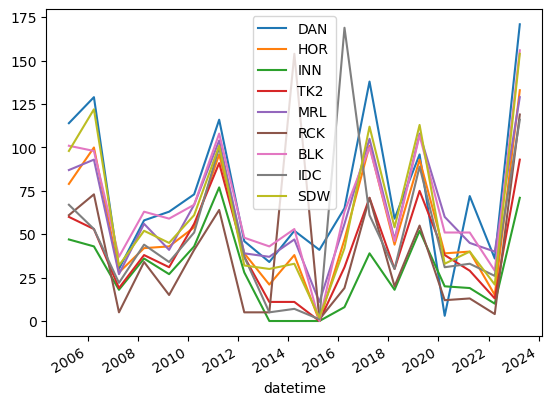

In [19]:
cdec_snwd_april1_nan.plot()

In [14]:
# Remove CDEC site locations that were eliminated from cdec_depth in the nan removal step
cdec_nan_locations = cdec_locations.copy()

index_list = []
for x in cdec_snwd_april1_nan.columns:
    index_list.append(x)
    
x_list = []
for x in cdec_nan_locations.id:
    x_list.append(x)

drop_list = []
for i in x_list:
    if i not in index_list:
        drop_list.append(cdec_nan_locations.index.get_loc(np.where(cdec_nan_locations['id']==i)[0][0]))

for i in drop_list:
    cdec_nan_locations = cdec_nan_locations.drop([i])

In [15]:
cdec_nan_locations

,name,id,datasource,geometry
48,DANA MEADOWS,DAN,CDEC,POINT Z (-119.25726 37.89616 9800.00000)
50,HORSE MEADOW (NRCS),HOR,CDEC,POINT Z (-119.88730 38.83650 8557.00000)
85,INDEPENDENCE CREEK,INN,CDEC,POINT Z (-120.29300 39.49400 6500.00000)
115,TRUCKEE 2,TK2,CDEC,POINT Z (-120.19400 39.30000 6400.00000)
117,MARLETTE LAKE,MRL,CDEC,POINT Z (-119.90500 39.17300 8000.00000)
123,ROCK CREEK LAKES,RCK,CDEC,POINT Z (-118.73502 37.45728 9700.00000)
148,BLUE LAKES,BLK,CDEC,POINT Z (-119.93100 38.61300 8000.00000)
150,INDEPENDENCE CAMP,IDC,CDEC,POINT Z (-120.29855 39.45259 7000.00000)
168,SUMMIT MEADOW,SDW,CDEC,POINT Z (-119.53560 38.39750 9313.00000)


(37.0, 41.0)

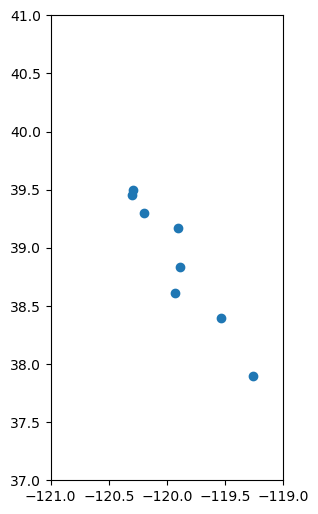

In [22]:
fig, ax = plt.subplots(figsize=(3,10))

#western_snotel.plot(ax=ax)
cdec_nan_locations.plot(ax=ax)
ax.set_xlim(-121,-119)
ax.set_ylim(37,41)

In [16]:
cdec_april1_anom = cdec_snwd_april1_nan - np.nanmean(cdec_snwd_april1_nan, axis=0)

In [18]:
cdec_april1_anom.to_pickle('../data/cdec/cdec_april1_anom.pkl')
cdec_nan_locations.to_pickle('../data/cdec/cdec_nan_locations.pkl')